# Clustering

Chapter 19 of [Data Science from Scratch](http://shop.oreilly.com/product/0636920033400.do). Joel's code: [clustering.py](https://github.com/joelgrus/data-science-from-scratch/blob/master/code-python3/clustering.py)

In [68]:
import math
import os
import random
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
book_dir = Path().resolve().parent.as_posix()
sys.path.extend(os.path.join(book_dir, 'chapter_{:02d}'.format(i)) for i in [3,4,5,6,7,8,16])

In [7]:
from vector import dot, vector_add, vector_mean, squared_distance, vector_mean, distance

## k-means

In [31]:
class KMeans:
    """performs k-means clustering"""
    
    def __init__(self, k):
        self.k = k
        self.means = None
    
    def classify(self, input):
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs):
        # choose k random points as the initial means
        self.means = random.sample(inputs, self.k)
        assignments = None
        
        while True:
            # Find new assignments
            new_assignments = [self.classify(i) for i in inputs]
            
            # If no assignments have changed, we're done.
            if assignments == new_assignments:
                return

            # Otherwise keep the new assignments,
            assignments = new_assignments
            
            # And compute new means based on the new assignments
            for i in range(self.k):
                # find all the points assigned to cluster i
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                
                # make sure i_points is not empty so don't divide by 0
                if i_points:
                    self.means[i] = vector_mean(i_points)

In [32]:
inputs = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

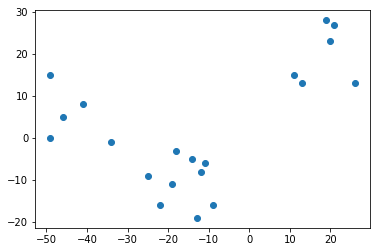

In [33]:
plt.scatter([x for x,y in inputs], [y for x,y in inputs])

In [143]:
#random.seed(4)
clusterer = KMeans(3)
clusterer.train(inputs)
print(clusterer.means)

[[18.333333333333332, 19.833333333333332], [-43.800000000000004, 5.4], [-15.888888888888888, -10.333333333333332]]


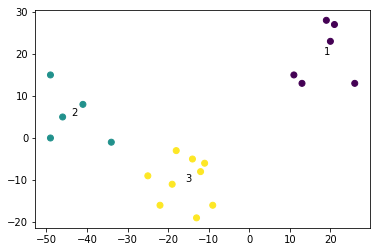

In [144]:
plt.scatter([x for x,y in inputs], [y for x,y in inputs],
            c=[clusterer.classify(i) for i in inputs])
plt.text(clusterer.means[0][0], clusterer.means[0][1], '1')
plt.text(clusterer.means[1][0], clusterer.means[1][1], '2')
plt.text(clusterer.means[2][0], clusterer.means[2][1], '3')
plt.show()

In [60]:
random.seed(4)
clusterer = KMeans(2)
clusterer.train(inputs)
print(clusterer.means)

[[18.333333333333332, 19.833333333333332], [-25.857142857142854, -4.714285714285714]]


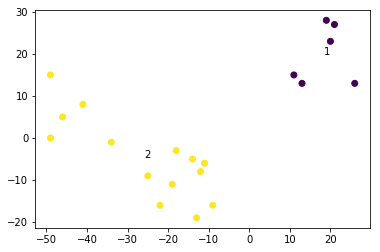

In [61]:
plt.scatter([x for x,y in inputs], [y for x,y in inputs],
            c=[clusterer.classify(i) for i in inputs])
plt.text(clusterer.means[0][0], clusterer.means[0][1], '1')
plt.text(clusterer.means[1][0], clusterer.means[1][1], '2')
plt.show()

### Choosing k

In [62]:
def squared_clustering_errors(inputs, k):
    """finds the total squared error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = list(map(clusterer.classify, inputs))

    return sum(squared_distance(input,means[cluster])
               for input, cluster in zip(inputs, assignments))

In [63]:
ks = range(1, len(inputs) + 1)
errors = [squared_clustering_errors(inputs, k) for k in ks]

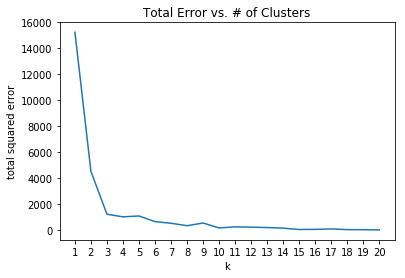

In [65]:
plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total squared error")
plt.title("Total Error vs. # of Clusters")
plt.show()

### Example: Clustering Colors

In [79]:
path_to_png_file = '/Users/cbare/Documents/images/39204639836.png'
img = mpimg.imread(path_to_png_file)

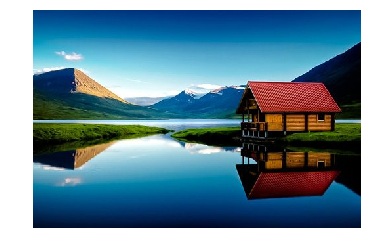

In [86]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [80]:
top_row = img[0]
top_left_pixel = top_row[0]
red, green, blue, alpha = top_left_pixel
red, green, blue, alpha

(0.0, 0.24705882, 0.49803922, 1.0)

In [81]:
pixels = [pixel for row in img for pixel in row]

In [82]:
clusterer = KMeans(5)
clusterer.train(pixels)

In [83]:
def recolor(pixel):
    cluster = clusterer.classify(pixel)
    return clusterer.means[cluster]

In [84]:
new_img = [[recolor(pixel) for pixel in row] for row in img]

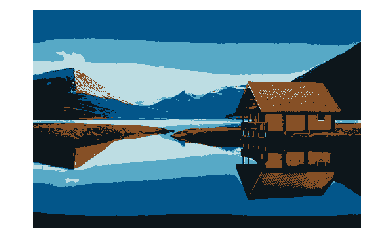

In [85]:
plt.imshow(new_img)
plt.axis('off')
plt.show()

## Hierarchical clustering

In [87]:
def is_leaf(cluster):
    """a cluster is a leaf if it has length 1"""
    return len(cluster) == 1

In [88]:
def get_children(cluster):
    """
    returns the two children of this cluster if it's a merged
    cluster; raises an exception if this is a leaf cluster
    """
    if is_leaf(cluster):
        raise TypeError("a leaf cluster has no children")
    else:
        return cluster[1]

In [89]:
def get_values(cluster):
    """returns the value in this cluster (if it's a leaf cluster)
    or all the values in the leaf clusters below it (if it's not)"""
    if is_leaf(cluster):
        return cluster
    else:
        return [value
                for child in get_children(cluster)
                for value in get_values(child)]

In [90]:
def cluster_distance(cluster1, cluster2, distance_agg=min):
    """compute all the pairwise distances between cluster1 and cluster2
    and apply _distance_agg_ to the resulting list"""
    return distance_agg([distance(input1, input2)
                         for input1 in get_values(cluster1)
                         for input2 in get_values(cluster2)])

In [91]:
def get_merge_order(cluster):
    if is_leaf(cluster):
        return float('inf')
    else:
        return cluster[0]

In [92]:
def bottom_up_cluster(inputs, distance_agg=min):
    # start with every input a leaf cluster / 1-tuple
    clusters = [(input,) for input in inputs]

    # as long as we have more than one cluster left...
    while len(clusters) > 1:
        # find the two closest clusters
        c1, c2 = min([(cluster1, cluster2)
                     for i, cluster1 in enumerate(clusters)
                     for cluster2 in clusters[:i]],
                     key=lambda p: cluster_distance(p[0], p[1], distance_agg))

        # remove them from the list of clusters
        clusters = [c for c in clusters if c != c1 and c != c2]

        # merge them, using merge_order = # of clusters left
        merged_cluster = (len(clusters), [c1, c2])

        # and add their merge
        clusters.append(merged_cluster)

    # when there's only one cluster left, return it
    return clusters[0]

In [93]:
def generate_clusters(base_cluster, num_clusters):
    # start with a list with just the base cluster
    clusters = [base_cluster]

    # as long as we don't have enough clusters yet...
    while len(clusters) < num_clusters:
        # choose the last-merged of our clusters
        next_cluster = min(clusters, key=get_merge_order)
        # remove it from the list
        clusters = [c for c in clusters if c != next_cluster]
        # and add its children to the list (i.e., unmerge it)
        clusters.extend(get_children(next_cluster))

    # once we have enough clusters...
    return clusters

In [103]:
base_cluster = bottom_up_cluster(inputs)
base_cluster

(0,
 [(1,
   [(3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]),
    (16, [([11, 15],), ([13, 13],)])]),
  (2,
   [(4,
     [(5,
       [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]),
      ([-34, -1],)]),
    (6,
     [(7,
       [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]),
        (13,
         [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]),
          ([-18, -3],)])]),
      (12, [([-13, -19],), ([-9, -16],)])])])])

three clusters, min

In [104]:
clusters = generate_clusters(base_cluster, 3)
clusters

[(2,
  [(4,
    [(5, [(9, [(11, [([-49, 0],), ([-46, 5],)]), ([-41, 8],)]), ([-49, 15],)]),
     ([-34, -1],)]),
   (6,
    [(7,
      [(8, [(10, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)]),
       (13,
        [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]),
         ([-18, -3],)])]),
     (12, [([-13, -19],), ([-9, -16],)])])]),
 (3, [(14, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)]), ([26, 13],)]),
 (16, [([11, 15],), ([13, 13],)])]

In [124]:
c, x, y = zip(*((i, item[0], item[1]) 
           for i, cluster in enumerate(clusters)
           for item in get_values(cluster)))

In [130]:
cluster_means = [vector_mean(get_values(cluster)) for cluster in clusters]
cluster_means

[[-25.857142857142854, -4.714285714285714], [21.5, 22.75], [12.0, 14.0]]

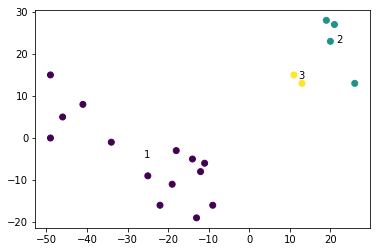

In [132]:
plt.scatter(x, y, c=c)
plt.text(cluster_means[0][0], cluster_means[0][1], '1')
plt.text(cluster_means[1][0], cluster_means[1][1], '2')
plt.text(cluster_means[2][0], cluster_means[2][1], '3')
plt.show()

three clusters, max

In [133]:
base_cluster = bottom_up_cluster(inputs, max)
clusters = generate_clusters(base_cluster, 3)
clusters

[(4,
  [(5, [(16, [([11, 15],), ([13, 13],)]), ([26, 13],)]),
   (13, [(18, [([19, 28],), ([21, 27],)]), ([20, 23],)])]),
 (2,
  [(6, [(8, [([-41, 8],), ([-49, 15],)]), (12, [([-49, 0],), ([-46, 5],)])]),
   ([-34, -1],)]),
 (3,
  [(7,
    [(9,
      [(15, [(17, [([-11, -6],), ([-12, -8],)]), ([-14, -5],)]),
       ([-18, -3],)]),
     (10, [(11, [([-22, -16],), ([-19, -11],)]), ([-25, -9],)])]),
   (14, [([-13, -19],), ([-9, -16],)])])]

In [134]:
c, x, y = zip(*((i, item[0], item[1]) 
           for i, cluster in enumerate(clusters)
           for item in get_values(cluster)))

In [135]:
cluster_means = [vector_mean(get_values(cluster)) for cluster in clusters]
cluster_means

[[18.333333333333332, 19.833333333333332],
 [-43.800000000000004, 5.4],
 [-15.888888888888888, -10.333333333333332]]

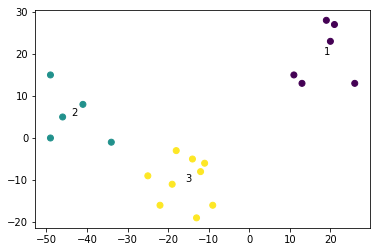

In [136]:
plt.scatter(x, y, c=c)
plt.text(cluster_means[0][0], cluster_means[0][1], '1')
plt.text(cluster_means[1][0], cluster_means[1][1], '2')
plt.text(cluster_means[2][0], cluster_means[2][1], '3')
plt.show()